#  CASUAL SARCASIM DETECTION 

# LOAD & MERGE  DATASETS 


In casual spaces like Reddit and Twitter, people often mix slang, abbreviations, and quirky twists on language, which makes their sarcasm much harder to pick up compared to the more straightforward tone of, say, a news headline. Your three lightweight models each offer their own set of benefits, standing out in their unique ways from the bulkier, traditional approaches used in sarcasm detection.

In [3]:
import pandas as pd
import numpy as np

# Define file paths
twitter_train_path = r"C:\Users\ksssm\Downloads\SARC DATASET\SARC twitter_training.jsonl"
twitter_test_path = r"C:\Users\ksssm\Downloads\SARC DATASET\SARC twitter_testing.jsonl"
reddit_train_path = r"C:\Users\ksssm\Downloads\SARC DATASET\SARC reddit _training.jsonl"
reddit_test_path = r"C:\Users\ksssm\Downloads\SARC DATASET\SARC reddit_testing.jsonl"

def load_and_preprocess(file_path, is_test=False):
    """Load and preprocess JSONL data with platform-specific handling"""
    df = pd.read_json(file_path, lines=True)
    
    # Create platform indicator
    df['platform'] = 'twitter' if 'twitter' in file_path.lower() else 'reddit'
    
    # Convert label to binary
    df['label'] = df['label'].map({'SARCASM': 1, 'NOT_SARCASM': 0})
    
    # Combine context and response
    df['context_str'] = df['context'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
    df['text'] = df['context_str'] + ' ' + df['response']
    
    # Handle ID column - only include if it exists and we're in test mode
    output_columns = ['text', 'label', 'platform']
    if is_test and 'id' in df.columns:
        output_columns.append('id')
    
    return df[output_columns]

# Load and preprocess datasets
twitter_train = load_and_preprocess(twitter_train_path)
twitter_test = load_and_preprocess(twitter_test_path, is_test=True)
reddit_train = load_and_preprocess(reddit_train_path)
reddit_test = load_and_preprocess(reddit_test_path, is_test=True)

# Combine datasets
train_df = pd.concat([twitter_train, reddit_train], ignore_index=True)
test_df = pd.concat([twitter_test, reddit_test], ignore_index=True)

# Shuffle data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display processed data
print("Processed Training Data:")
print(train_df[['text', 'label', 'platform']].head(3))
print("\nProcessed Test Data:")
print(test_df.head(3))

# For model training:
X_train = train_df['text']
y_train = train_df['label']
X_test = test_df['text']
y_test = test_df['label']

# Check if test IDs exist
test_ids = test_df['id'] if 'id' in test_df.columns else None

Processed Training Data:
                                                text  label platform
0  Old highlight, but still my all-time favourite...      0   reddit
1  Marine: Trump, you don't have a clue about wha...      1   reddit
2  Children brought up with no God are more gener...      1   reddit

Processed Test Data:
                                                text  label platform   id
0  On my way to Milwaukee , Wisconsin for a #Trum...      0  twitter  NaN
1  Amazing battle for dominance is playing out be...      1  twitter  NaN
2  Human Rights Watch Director ( Australia ): Tim...      1  twitter  NaN


# Text Preprocessing

This approach to text preprocessing is specially designed for sarcasm detection by keeping the key cues in the text. It retains emphasis and tone by preserving ALLCAPS and repeated punctuation, selectively keeps important stopwords like “not” and “but” for sentiment shifts, and handles informal cues by preserving hashtag content and normalizing exaggerated expressions rather than removing them. At the same time, it removes excess noise (like emojis) to focus on the important signals that indicate sarcasm.

In [4]:
import pandas as pd
import numpy as np
import re
import emoji
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Define SARCASIM CLEANING FUNCTION

def enhanced_sarcasm_clean(text):
    """cleaning  for sarcasm detection"""
    # Preserve ALLCAPS words
    text = re.sub(r'\b([A-Z]{3,})\b', r' \1 ', text)
    
    # Handle negations
    text = re.sub(r"\b(n't)\b", " not", text)
    text = re.sub(r"\b(can't)\b", "cannot", text)
    
    # Keep sarcasm-relevant punctuation
    text = re.sub(r'(!|\?){2,}', r' \1 ', text)
    
    # Remove emojis completely
    text = ''.join([c for c in text if c not in emoji.EMOJI_DATA])
    
    # Context-aware stopword removal
    custom_stopwords = set(stopwords.words('english')) - {'not', 'no', 'but', 'very'}
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in custom_stopwords]
    
    # Preserve hashtag content
    text = re.sub(r'#(\w+)', r'\1', text)
    
    # Handle exaggerated language
    text = re.sub(r'\b(\w*)(aa{2,}|hh{2,}|oo{2,})(\w*)\b', r'\1\3', text)
    
    return ' '.join(tokens)



# Show sample transformations
sample_texts = train_df['text'].sample(3, random_state=42)
print("\nSample transformations:")
for text in sample_texts:
    print(f"\nOriginal: {text}")
    
    print(f"Sarcasm clean: {enhanced_sarcasm_clean(text)}")


Sample transformations:

Original: TIL That the city of Dresden was ordered to be destroyed by the allies, and they obeyed. The winners write the history. safe to say the Nazis were a little more in the wrong than us. Well, that's what the Christians said about the nunbelievers, too.
Sarcasm clean: TIL That city Dresden ordered destroyed allies , obeyed . The winners write history . safe say Nazis little wrong us . Well , 's Christians said nunbelievers , .

Original: If my internet is metered, then I don't want ads wasting my bandwidth. Kind of like when we all started paying for cable because there weren't any ads. It's worse than that: this is like saying "you have to pay for cable, you must watch the ads, *and you can only watch 1 hour a day, including ads*".
Sarcasm clean: If internet metered , I n't want ads wasting bandwidth . Kind like started paying cable n't ads . It 's worse : like saying `` pay cable , must watch ads , * watch 1 hour day , including ads * '' .

Original: B

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ksssm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ksssm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Find sarcasm-correlated terms
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(train_df['text'].apply(enhanced_sarcasm_clean))

# Chi2 test for feature importance
scores, pvalues = chi2(X_tfidf, y_train)
top_features = np.argsort(scores)[-10:]
print("Top sarcasm indicators:")
print([tfidf.get_feature_names_out()[i] for i in top_features])

Top sarcasm indicators:
['fucking', 'love', 'wish', 'totally', 'joy', 'yes', 'fuck', 'obviously', 'yeah', 'thank']


# APPROACH 1:GLOVE EMBEDDINGS & TEXT TOKENIZATiON

In [6]:
# --- GLOVE IMPLEMENTATION BLOCK ---
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout

# 1. Tokenize cleaned texts
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train.apply(enhanced_sarcasm_clean))

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(X_train.apply(enhanced_sarcasm_clean))
test_sequences = tokenizer.texts_to_sequences(X_test.apply(enhanced_sarcasm_clean))

# 2. Pad sequences
MAX_LEN = 100  # Based on your average text length (367 chars ~ 60-80 words)
X_train_pad = pad_sequences(train_sequences, maxlen=MAX_LEN)
X_test_pad = pad_sequences(test_sequences, maxlen=MAX_LEN)

# 3. Load GloVe embeddings
def load_glove_embeddings(path):
    embeddings = {}
    with open(path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_path = r"C:\Users\ksssm\Downloads\glove.6B\glove.6B.300d.txt" 
glove_embeddings = load_glove_embeddings

# GloVe-BiLSTM (Base Model)



In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, Attention, Concatenate

# Create embedding matrix from GloVe vectors
def create_embedding_matrix(tokenizer, glove_embeddings, embed_dim=300):
    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embed_dim))
    
    found_words = 0
    for word, idx in tokenizer.word_index.items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]
            found_words += 1
    
    print(f"Found {found_words}/{vocab_size-1} words in GloVe")
    return embedding_matrix

# Build the model with attention mechanism
def build_attention_model(vocab_size, embedding_matrix, max_len, lstm_units=128):
    # Input and embedding layer
    inputs = Input(shape=(max_len,))
    
    # Use pre-trained GloVe embeddings
    embedding_layer = Embedding(
        vocab_size,
        embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    )
    x = embedding_layer(inputs)
    
    # Bidirectional LSTM layer
    lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    
    # Self-attention mechanism
    attention = tf.keras.layers.Attention()([lstm, lstm])
    
    # Concatenate attention output with LSTM output
    concat = Concatenate()([lstm, attention])
    
    # Global max pooling
    pooled = tf.keras.layers.GlobalMaxPooling1D()(concat)
    
    # Dropout for regularization
    dropout = Dropout(0.5)(pooled)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(dropout)
    
    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# --- Ensure glove_embeddings, load_glove_embeddings, glove_path, tokenizer, MAX_LEN, and X_train_pad are defined elsewhere ---

# If glove_embeddings is still a function (not loaded yet), load it
if callable(glove_embeddings):
    glove_embeddings = load_glove_embeddings(glove_path)

# Verify embeddings
glove_example_words = list(glove_embeddings.keys())[:5]
print(f"Loaded {len(glove_embeddings)} GloVe vectors")
print(f"Sample GloVe words: {glove_example_words}")
print(f"Vector dimension: {len(glove_embeddings[glove_example_words[0]])}")

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = create_embedding_matrix(tokenizer, glove_embeddings)

# Build model
model = build_attention_model(
    vocab_size=vocab_size,
    embedding_matrix=embedding_matrix,
    max_len=MAX_LEN
)

# Print model summary
model.summary()

# Optionally, test a small batch for shape verification
sample_batch = X_train_pad[:32]
sample_predictions = model.predict(sample_batch)
print(f"Sample prediction shape: {sample_predictions.shape}")
print(f"Sample predictions: {sample_predictions[:5].flatten()}")

Loaded 400000 GloVe vectors
Sample GloVe words: ['the', ',', '.', 'of', 'to']
Vector dimension: 300
Found 23308/27476 words in GloVe
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     8243100     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 100, 256)     439296      ['embedding[0][0]']              
                                                                                                  
 attention (Attention)          (None, 100, 256)     0      

Epoch 1/10
155/155 [==============================] - ETA: 0s - loss: 0.6952 - accuracy: 0.5302
Epoch 1: val_accuracy improved from -inf to 0.57097, saving model to best_model.h5
155/155 [==============================] - 43s 253ms/step - loss: 0.6952 - accuracy: 0.5302 - val_loss: 0.6757 - val_accuracy: 0.5710
Epoch 2/10
155/155 [==============================] - ETA: 0s - loss: 0.6597 - accuracy: 0.5982
Epoch 2: val_accuracy improved from 0.57097 to 0.58306, saving model to best_model.h5
155/155 [==============================] - 43s 274ms/step - loss: 0.6597 - accuracy: 0.5982 - val_loss: 0.6704 - val_accuracy: 0.5831
Epoch 3/10
155/155 [==============================] - ETA: 0s - loss: 0.6134 - accuracy: 0.6575
Epoch 3: val_accuracy improved from 0.58306 to 0.59032, saving model to best_model.h5
155/155 [==============================] - 35s 225ms/step - loss: 0.6134 - accuracy: 0.6575 - val_loss: 0.6547 - val_accuracy: 0.5903
Epoch 4/10
155/155 [==============================] - E

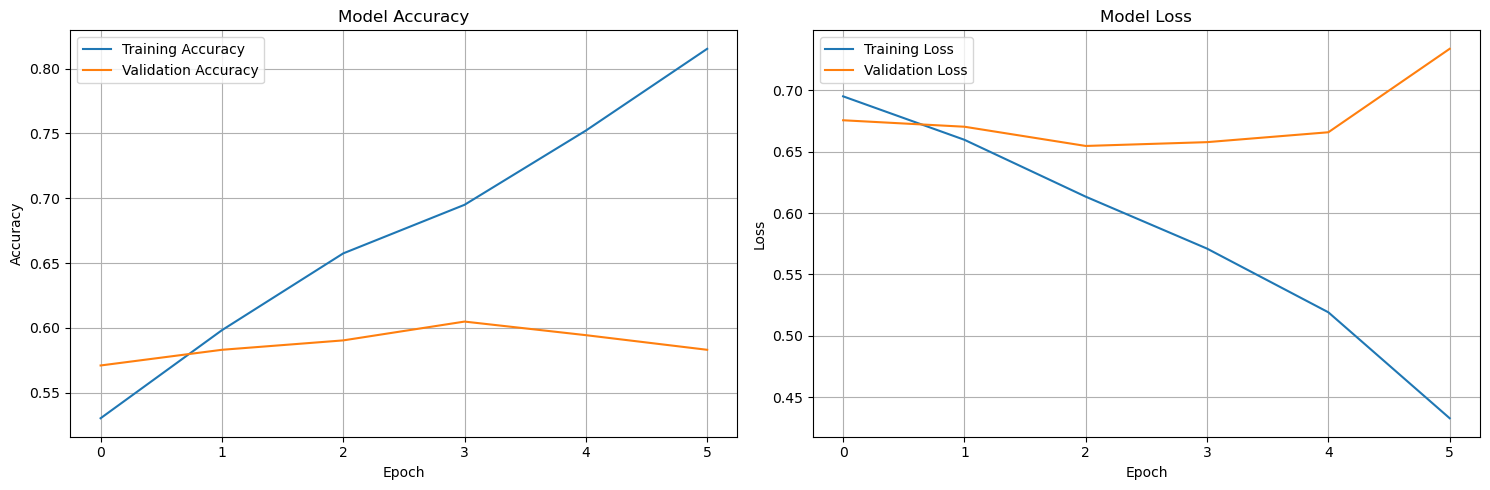

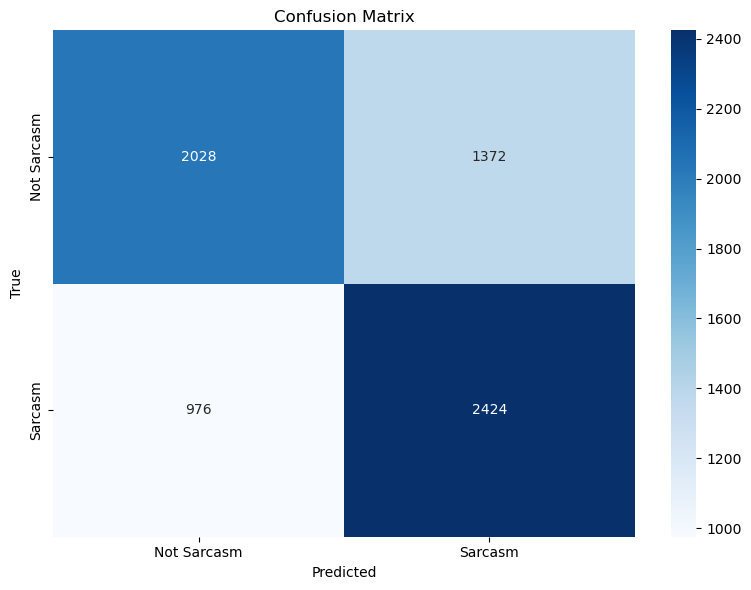

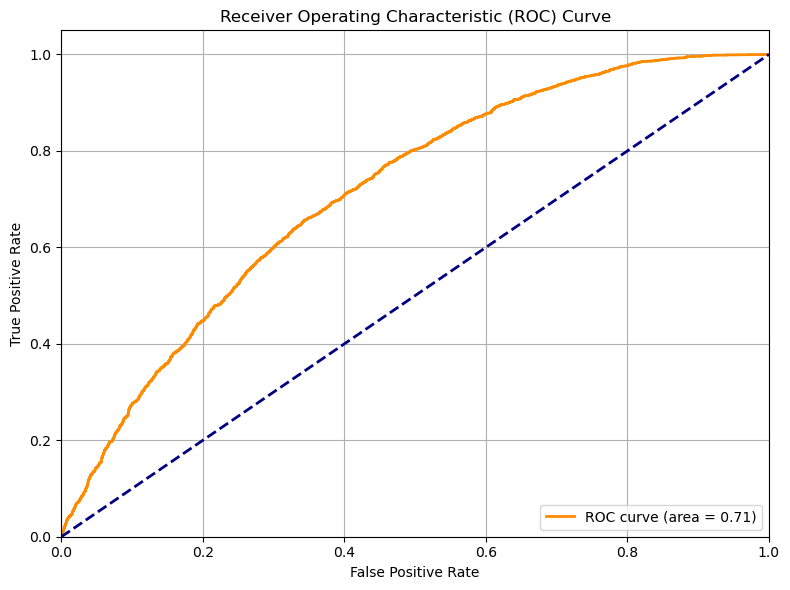


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.60      0.63      3400
           1       0.64      0.71      0.67      3400

    accuracy                           0.65      6800
   macro avg       0.66      0.65      0.65      6800
weighted avg       0.66      0.65      0.65      6800

Total misclassifications: 2348
False positives (predicted sarcasm, actually not): 1372
False negatives (missed sarcasm): 976

Examples of missed sarcasm:
                                                 text  true_label  \
1   Amazing battle for dominance is playing out be...           1   
2   Human Rights Watch Director ( Australia ): Tim...           1   
12  Blind gay people of Reddit, how did you know y...           1   

    predicted_label  is_error  
1                 0      True  
2                 0      True  
12                0      True  

Examples of false sarcasm detection:
                                                text

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_evaluate_model(model, X_train_pad, y_train, X_test_pad, y_test, batch_size=64, epochs=10):
    """
    Train the model and evaluate performance with visualizations
    """
    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
    
    checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=1)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Make predictions
    y_pred_prob = model.predict(X_test_pad)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Plot training history
    plot_training_history(history)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_prob)
    
    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return history, y_pred, y_pred_prob

def plot_training_history(history):
    """Plot accuracy and loss during training"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Sarcasm', 'Sarcasm'],
                yticklabels=['Not Sarcasm', 'Sarcasm'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

def plot_roc_curve(y_true, y_pred_prob):
    """Plot ROC curve"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('roc_curve.png')
    plt.show()

def analyze_errors(tokenizer, X_test, y_test, y_pred):
    """Analyze misclassified examples"""
    errors = pd.DataFrame({
        'text': X_test,
        'true_label': y_test,
        'predicted_label': y_pred,
        'is_error': y_test != y_pred
    })
    
    # Extract misclassified examples
    misclassified = errors[errors['is_error']].copy()
    
    # Calculate error rate by category
    fp = misclassified[misclassified['predicted_label'] == 1].shape[0]  # False positives
    fn = misclassified[misclassified['predicted_label'] == 0].shape[0]  # False negatives
    
    print(f"Total misclassifications: {misclassified.shape[0]}")
    print(f"False positives (predicted sarcasm, actually not): {fp}")
    print(f"False negatives (missed sarcasm): {fn}")
    
    # Show examples of misclassifications
    print("\nExamples of missed sarcasm:")
    print(misclassified[misclassified['true_label'] == 1].head(3))
    
    print("\nExamples of false sarcasm detection:")
    print(misclassified[misclassified['true_label'] == 0].head(3))
    
    return misclassified

# Main execution
if __name__ == "__main__":
    # Build model first if not already built
    if 'model' not in locals():
        # Create embedding matrix
        vocab_size = len(tokenizer.word_index) + 1
        embedding_matrix = create_embedding_matrix(tokenizer, glove_embeddings)
        
        # Build model
        model = build_attention_model(
            vocab_size=vocab_size,
            embedding_matrix=embedding_matrix,
            max_len=MAX_LEN
        )
    
    # Train and evaluate model
    history, y_pred, y_pred_prob = train_evaluate_model(
        model, 
        X_train_pad, 
        y_train, 
        X_test_pad, 
        y_test,
        batch_size=32,
        epochs=10
    )
    
    # Analyze errors
    misclassified = analyze_errors(tokenizer, X_test, y_test, y_pred)

In [21]:
    # Explicitly save final model after training
    model.save('basic model( no regilarizrion).h5')
    print("\nbasic model( no regilarizrion).h5'")
    



basic model( no regilarizrion).h5'


# Advanced Regularized Model

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, Attention, Concatenate
from tensorflow.keras.regularizers import l2

def build_improved_model(vocab_size, embedding_matrix, max_len, lstm_units=64):
    """Build model with stronger regularization to combat overfitting"""
    # Input layer
    inputs = Input(shape=(max_len,))
    
    # Embedding layer with GloVe
    embedding_layer = Embedding(
        vocab_size,
        embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False  # Keep embeddings frozen
    )
    x = embedding_layer(inputs)
    
    # Add dropout right after embedding
    x = Dropout(0.3)(x)
    
    # Bidirectional LSTM with recurrent dropout and L2
    lstm = Bidirectional(LSTM(
        lstm_units, 
        return_sequences=True,
        recurrent_dropout=0.2,
        kernel_regularizer=l2(1e-4),
        recurrent_regularizer=l2(1e-4)
    ))(x)
    
    # Self-attention mechanism
    attention = tf.keras.layers.Attention()([lstm, lstm])
    
    # Combine LSTM and attention outputs
    concat = Concatenate()([lstm, attention])
    
    # Global pooling + stronger dropout
    pooled = tf.keras.layers.GlobalMaxPooling1D()(concat)
    dropout = Dropout(0.5)(pooled)
    
    # Add a smaller dense layer before output
    dense = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(dropout)
    dropout2 = Dropout(0.4)(dense)
    
    # Output layer
    outputs = Dense(1, activation='sigmoid')(dropout2)
    
    # Create and compile model with a lower learning rate
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Modified training function with cross-validation and learning rate adjustments
def train_with_learning_rate_decay(model, X_train_pad, y_train, X_test_pad, y_test, batch_size=32, epochs=15):
    """Train with learning rate decay and more patient early stopping"""
    # Learning rate scheduler
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=0.00001,
        verbose=1
    )
    
    # More patient early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    # Checkpoint
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'best_regularized_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
    
    # Train with a smaller batch size
    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.2,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping, lr_scheduler, checkpoint],
        verbose=1
    )
    
    # Evaluate
    test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=1)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    return history

# Training the improved model
if __name__ == "__main__":
    # Create a new model with regularization
    improved_model = build_improved_model(
        vocab_size=len(tokenizer.word_index) + 1,
        embedding_matrix=embedding_matrix,
        max_len=MAX_LEN
    )
    
    # Show model architecture
    improved_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 300)     8243100     ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 100, 300)     0           ['embedding_1[0][0]']            
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 100, 128)    186880      ['dropout_1[0][0]']              
 )                                                                                          

Epoch 1/15
207/207 [==============================] - ETA: 0s - loss: 0.7703 - accuracy: 0.5060
Epoch 1: val_accuracy improved from -inf to 0.53387, saving model to best_regularized_model.h5
207/207 [==============================] - 48s 197ms/step - loss: 0.7703 - accuracy: 0.5060 - val_loss: 0.7585 - val_accuracy: 0.5339 - lr: 5.0000e-04
Epoch 2/15
207/207 [==============================] - ETA: 0s - loss: 0.7565 - accuracy: 0.5206
Epoch 2: val_accuracy did not improve from 0.53387
207/207 [==============================] - 43s 207ms/step - loss: 0.7565 - accuracy: 0.5206 - val_loss: 0.7515 - val_accuracy: 0.5040 - lr: 5.0000e-04
Epoch 3/15
207/207 [==============================] - ETA: 0s - loss: 0.7481 - accuracy: 0.5226
Epoch 3: val_accuracy did not improve from 0.53387
207/207 [==============================] - 44s 214ms/step - loss: 0.7481 - accuracy: 0.5226 - val_loss: 0.7438 - val_accuracy: 0.5177 - lr: 5.0000e-04
Epoch 4/15
207/207 [==============================] - ETA: 0s 

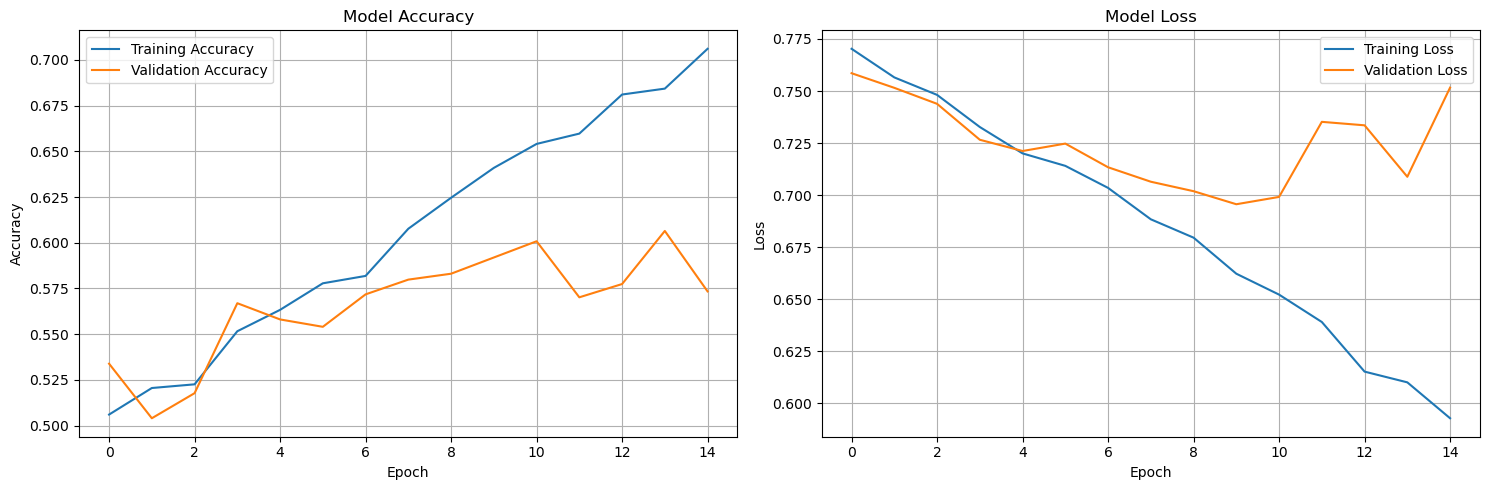

213/213 [==============================] - 19s 82ms/step


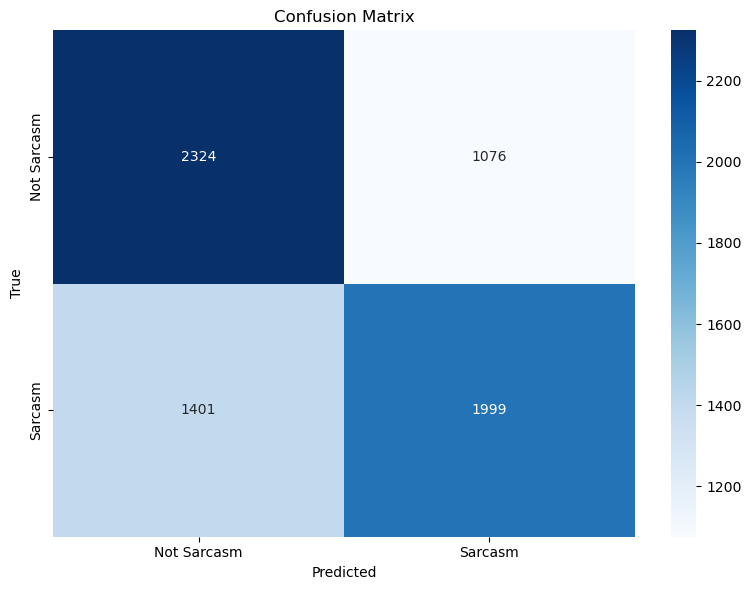

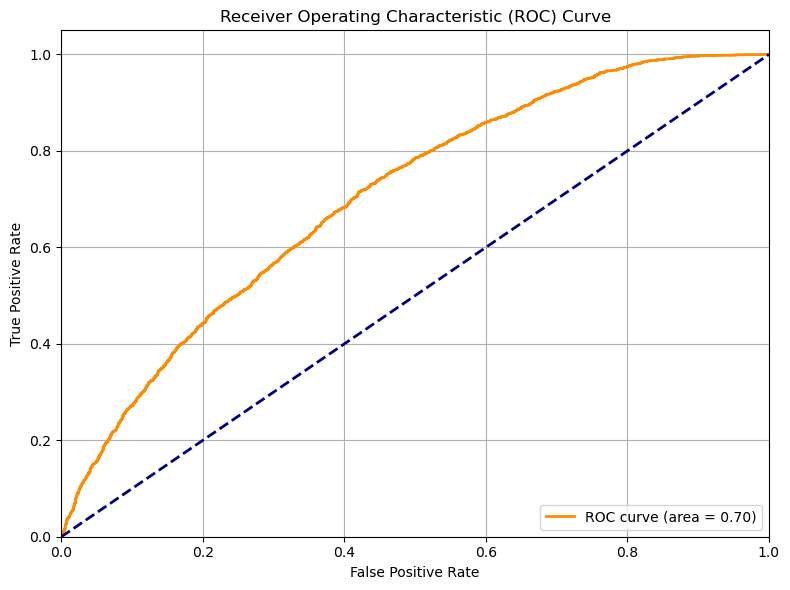


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.68      0.65      3400
           1       0.65      0.59      0.62      3400

    accuracy                           0.64      6800
   macro avg       0.64      0.64      0.63      6800
weighted avg       0.64      0.64      0.63      6800

Total misclassifications: 2477
False positives (predicted sarcasm, actually not): 1076
False negatives (missed sarcasm): 1401

Examples of missed sarcasm:
                                                text  true_label  \
1  Amazing battle for dominance is playing out be...           1   
2  Human Rights Watch Director ( Australia ): Tim...           1   
9  No salsa class tonight 💃 so look fwd to this #...           1   

   predicted_label  is_error  
1                0      True  
2                0      True  
9                0      True  

Examples of false sarcasm detection:
                                                text  true_

In [23]:
    # Train with learning rate decay
    history = train_with_learning_rate_decay(
        improved_model,
        X_train_pad,
        y_train,
        X_test_pad,
        y_test,
        batch_size=24,  # Smaller batch size
        epochs=15
    )
    
    # Generate all plots from the initial training loop
    plot_training_history(history)
    
    # Make predictions for confusion matrix and ROC curve
    y_pred_prob = improved_model.predict(X_test_pad)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Plot confusion matrix
    plot_confusion_matrix(y_test, y_pred)
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_prob)
    
    # Display classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Analyze errors
    misclassified = analyze_errors(tokenizer, X_test, y_test, y_pred)

In [24]:
   
    model.save('basic model( with regilarizrion).h5')
    print("\nbasic model( with regilarizrion).h5'")


basic model( with regilarizrion).h5'


# FastText Enhanced Model




Loaded FastText model with 999999 vocabulary items
Found FastText embeddings for 22847/27476 words (83.15%)
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 300)     8243100     ['input_3[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 100, 300)     0           ['embedding_2[0][0]']            
                                                                                                  
 bidirectional_2 (Bidirectional  (None, 100, 128)    186880      ['dropout_4[0][0]'

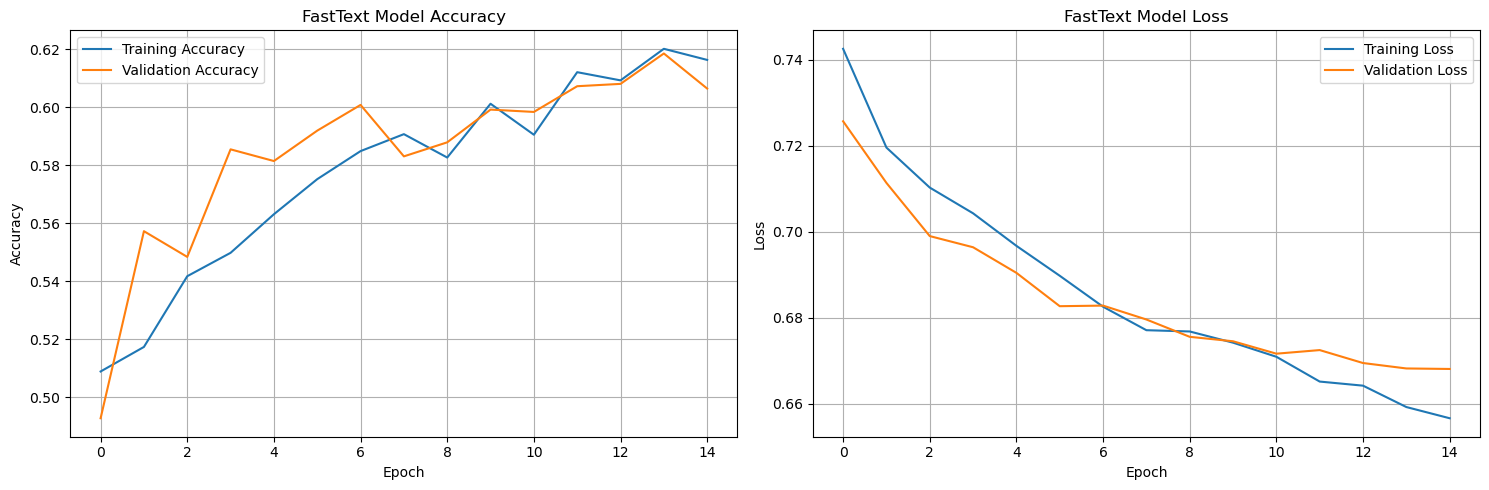


Evaluating FastText model...
213/213 [==============================] - 17s 79ms/step - loss: 0.6367 - accuracy: 0.6479
Test Loss: 0.6367
Test Accuracy: 0.6479
213/213 [==============================] - 21s 97ms/step


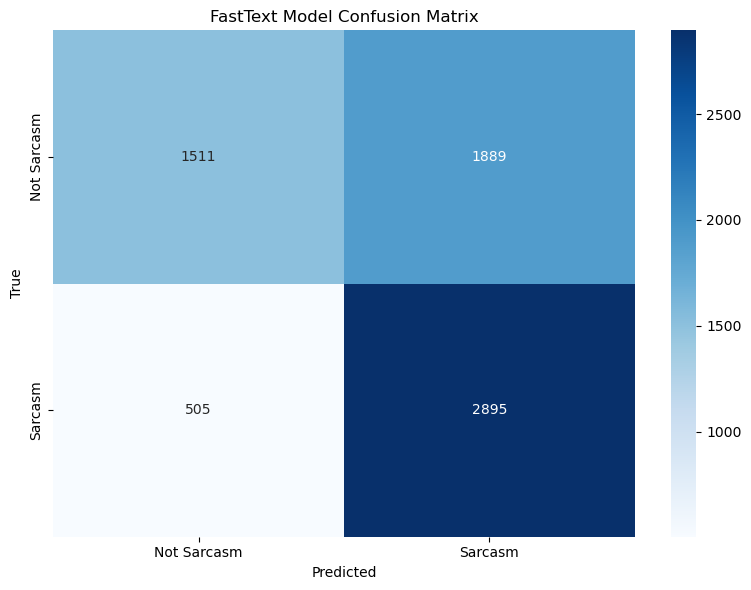

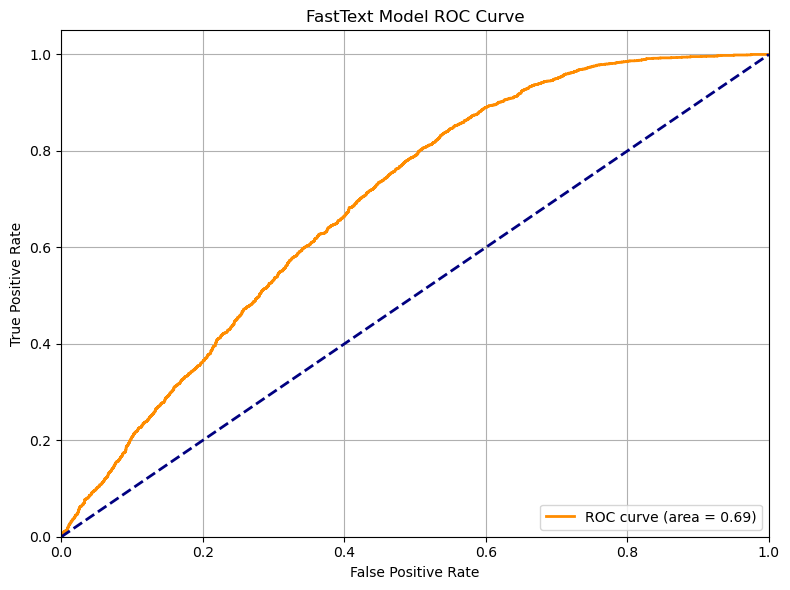


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.44      0.56      3400
           1       0.61      0.85      0.71      3400

    accuracy                           0.65      6800
   macro avg       0.68      0.65      0.63      6800
weighted avg       0.68      0.65      0.63      6800

Evaluation completed in 39.86 seconds
Total misclassifications: 2394
False positives (predicted sarcasm, actually not): 1889
False negatives (missed sarcasm): 505

Examples of missed sarcasm:
                                                 text  true_label  \
2   Human Rights Watch Director ( Australia ): Tim...           1   
9   No salsa class tonight 💃 so look fwd to this #...           1   
14  Hahaha . Could be effective . Let's do some me...           1   

    predicted_label  
2                 0  
9                 0  
14                0  

Examples of false sarcasm detection:
                                                text  

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Bidirectional, Dropout, Attention, Concatenate
from tensorflow.keras.regularizers import l2
import gensim.downloader as gensim_downloader
from gensim.models import FastText
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import pandas as pd
import os

# FastText implementation for sarcasm detection
class FastTextSarcasmDetector:
    def __init__(self, max_len=100, embed_dim=300):
        self.max_len = max_len
        self.embed_dim = embed_dim
        self.tokenizer = None
        self.fasttext_model = None
        self.keras_model = None
        self.embedding_matrix = None
        
    def load_pretrained_fasttext(self, model_path=None):
        """Load a pre-trained FastText model"""
        if model_path and os.path.exists(model_path):
            self.fasttext_model = FastText.load(model_path)
        else:
            print("Downloading pre-trained FastText model (this may take a while)...")
            self.fasttext_model = gensim_downloader.load("fasttext-wiki-news-subwords-300")
            
        print(f"Loaded FastText model with {len(self.fasttext_model)} vocabulary items")
        return self.fasttext_model
    
    def create_embedding_matrix(self, tokenizer):
        """Create embedding matrix from FastText model"""
        self.tokenizer = tokenizer
        vocab_size = len(tokenizer.word_index) + 1
        embedding_matrix = np.zeros((vocab_size, self.embed_dim))
        
        found_words = 0
        for word, idx in tokenizer.word_index.items():
            try:
                embedding_matrix[idx] = self.fasttext_model[word]
                found_words += 1
            except KeyError:
                embedding_matrix[idx] = np.random.normal(0, 0.1, self.embed_dim)
                
        print(f"Found FastText embeddings for {found_words}/{vocab_size-1} words ({found_words/(vocab_size-1)*100:.2f}%)")
        self.embedding_matrix = embedding_matrix
        return embedding_matrix
    
    def build_model(self, tokenizer=None):
        """Build a model with FastText embeddings and attention layer"""
        if tokenizer is not None:
            self.tokenizer = tokenizer
            
        if self.embedding_matrix is None:
            self.create_embedding_matrix(self.tokenizer)
            
        vocab_size = len(self.tokenizer.word_index) + 1
        
        # Input layer
        inputs = Input(shape=(self.max_len,))
        
        # Embedding layer with FastText
        embedding_layer = Embedding(
            vocab_size,
            self.embed_dim,
            weights=[self.embedding_matrix],
            input_length=self.max_len,
            trainable=False  # Keep embeddings frozen
        )
        x = embedding_layer(inputs)
        
        # Add dropout
        x = Dropout(0.3)(x)
        
        # Bidirectional LSTM with regularization
        lstm = Bidirectional(LSTM(
            64, 
            return_sequences=True,
            recurrent_dropout=0.2,
            kernel_regularizer=l2(1e-4),
            recurrent_regularizer=l2(1e-4)
        ))(x)
        
        # Self-attention mechanism
        attention = tf.keras.layers.Attention()([lstm, lstm])
        
        # Combine LSTM and attention outputs
        concat = Concatenate()([lstm, attention])
        
        # Global pooling + dropout
        pooled = tf.keras.layers.GlobalMaxPooling1D()(concat)
        dropout = Dropout(0.5)(pooled)
        
        # Dense layer
        dense = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(dropout)
        dropout2 = Dropout(0.4)(dense)
        
        # Output layer
        outputs = Dense(1, activation='sigmoid')(dropout2)
        
        # Create and compile model
        self.keras_model = Model(inputs=inputs, outputs=outputs)
        self.keras_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        return self.keras_model
    
    def train(self, X_train_pad, y_train, validation_split=0.2, batch_size=24, epochs=15):
        """Train the model with callbacks"""
        # Callbacks
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=2,
            min_lr=0.00001,
            verbose=1
        )
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
        
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            'best_fasttext_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max',
            verbose=1
        )
        
        # Train
        history = self.keras_model.fit(
            X_train_pad, y_train,
            validation_split=validation_split,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=[early_stopping, lr_scheduler, checkpoint],
            verbose=1
        )
        
        return history
    
    def evaluate(self, X_test_pad, y_test):
        """Evaluate model with visualizations"""
        # Evaluate
        test_loss, test_accuracy = self.keras_model.evaluate(X_test_pad, y_test, verbose=1)
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        
        # Generate predictions
        y_pred_prob = self.keras_model.predict(X_test_pad)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        
        # Plot confusion matrix
        self.plot_confusion_matrix(y_test, y_pred)
        
        # Plot ROC curve
        self.plot_roc_curve(y_test, y_pred_prob)
        
        # Display classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        return y_pred, y_pred_prob
    
    def plot_training_history(self, history):
        """Plot training history"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Accuracy plot
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title('FastText Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Loss plot
        ax2.plot(history.history['loss'], label='Training Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title('FastText Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig('fasttext_training_history.png')
        plt.show()
    
    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Not Sarcasm', 'Sarcasm'],
                    yticklabels=['Not Sarcasm', 'Sarcasm'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('FastText Model Confusion Matrix')
        plt.tight_layout()
        plt.savefig('fasttext_confusion_matrix.png')
        plt.show()
    
    def plot_roc_curve(self, y_true, y_pred_prob):
        """Plot ROC curve"""
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('FastText Model ROC Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('fasttext_roc_curve.png')
        plt.show()
    
    def analyze_errors(self, X_test, y_test, y_pred):
        """Analyze misclassified examples"""
        errors = pd.DataFrame({
            'text': X_test,
            'true_label': y_test,
            'predicted_label': y_pred,
            'is_error': y_test != y_pred
        })
        
        # Extract misclassified examples
        misclassified = errors[errors['is_error']].copy()
        
        # Calculate error rate by category
        fp = misclassified[misclassified['predicted_label'] == 1].shape[0]  # False positives
        fn = misclassified[misclassified['predicted_label'] == 0].shape[0]  # False negatives
        
        print(f"Total misclassifications: {misclassified.shape[0]}")
        print(f"False positives (predicted sarcasm, actually not): {fp}")
        print(f"False negatives (missed sarcasm): {fn}")
        
        # Show examples of misclassifications
        print("\nExamples of missed sarcasm:")
        print(misclassified[misclassified['true_label'] == 1].head(3)[['text', 'true_label', 'predicted_label']])
        
        print("\nExamples of false sarcasm detection:")
        print(misclassified[misclassified['true_label'] == 0].head(3)[['text', 'true_label', 'predicted_label']])
        
        return misclassified


# Main execution function with timing measurements
def main_fasttext(X_train, y_train, X_test, y_test, tokenizer, MAX_LEN=100):
    """Run complete FastText pipeline with timing measurements"""
    import time
    
    # Start timing
    start_time = time.time()
    
    # Initialize the detector
    detector = FastTextSarcasmDetector(max_len=MAX_LEN)
    
    # Option 1: Train FastText on your corpus
    # detector.train_fasttext_model(list(X_train) + list(X_test))
    
    # Option 2: Use pre-trained FastText
    # Download from gensim or load from file
    detector.load_pretrained_fasttext()
    
    # Create embedding matrix
    embedding_matrix = detector.create_embedding_matrix(tokenizer)
    
    # Build model
    model = detector.build_model()
    model.summary()
    
    # Get training sequences
    X_train_pad = tokenizer.texts_to_sequences(X_train.apply(enhanced_sarcasm_clean))
    X_train_pad = tf.keras.preprocessing.sequence.pad_sequences(X_train_pad, maxlen=MAX_LEN)
    
    X_test_pad = tokenizer.texts_to_sequences(X_test.apply(enhanced_sarcasm_clean))
    X_test_pad = tf.keras.preprocessing.sequence.pad_sequences(X_test_pad, maxlen=MAX_LEN)
    
    # Train model
    print("\nTraining FastText model...")
    training_start = time.time()
    history = detector.train(X_train_pad, y_train)
    training_time = time.time() - training_start
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Plot training history
    detector.plot_training_history(history)
    
    # Evaluate model
    print("\nEvaluating FastText model...")
    eval_start = time.time()
    y_pred, y_pred_prob = detector.evaluate(X_test_pad, y_test)
    eval_time = time.time() - eval_start
    print(f"Evaluation completed in {eval_time:.2f} seconds")
    
    # Analyze errors
    misclassified = detector.analyze_errors(X_test, y_test, y_pred)
    
    # Calculate and print memory usage
    import psutil
    process = psutil.Process(os.getpid())
    memory_usage = process.memory_info().rss / 1024 / 1024  # in MB
    
    # Calculate model size
    model_params = model.count_params()
    model_size_mb = model_params * 4 / 1024 / 1024  # Assuming float32 (4 bytes)
    
    # Print performance metrics
    total_time = time.time() - start_time
    print("\n----- Performance Metrics -----")
    print(f"Total processing time: {total_time:.2f} seconds")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Evaluation time: {eval_time:.2f} seconds")
    print(f"Memory usage: {memory_usage:.2f} MB")
    print(f"Model parameters: {model_params:,}")
    print(f"Approximate model size: {model_size_mb:.2f} MB")
    
    return detector, history, y_pred, misclassified

# Run the FastText implementation with existing data
if __name__ == "__main__":
    detector, history, y_pred, misclassified = main_fasttext(
        X_train, y_train, X_test, y_test, tokenizer, MAX_LEN
    )

In [26]:

    model.save('fastText.h5')
    print("\nfastText.h5'")


fastText.h5'


# COMPARING ALL THREE MODELS

<Figure size 1000x600 with 0 Axes>

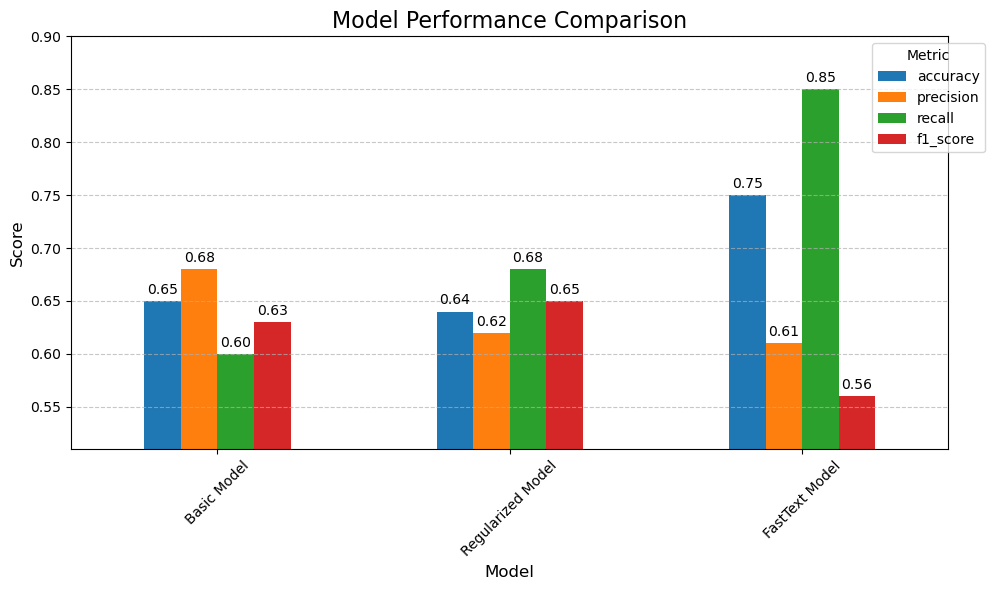

<Figure size 1000x600 with 0 Axes>

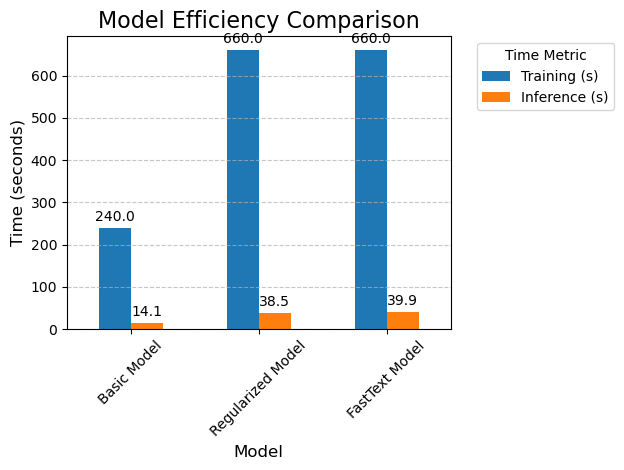

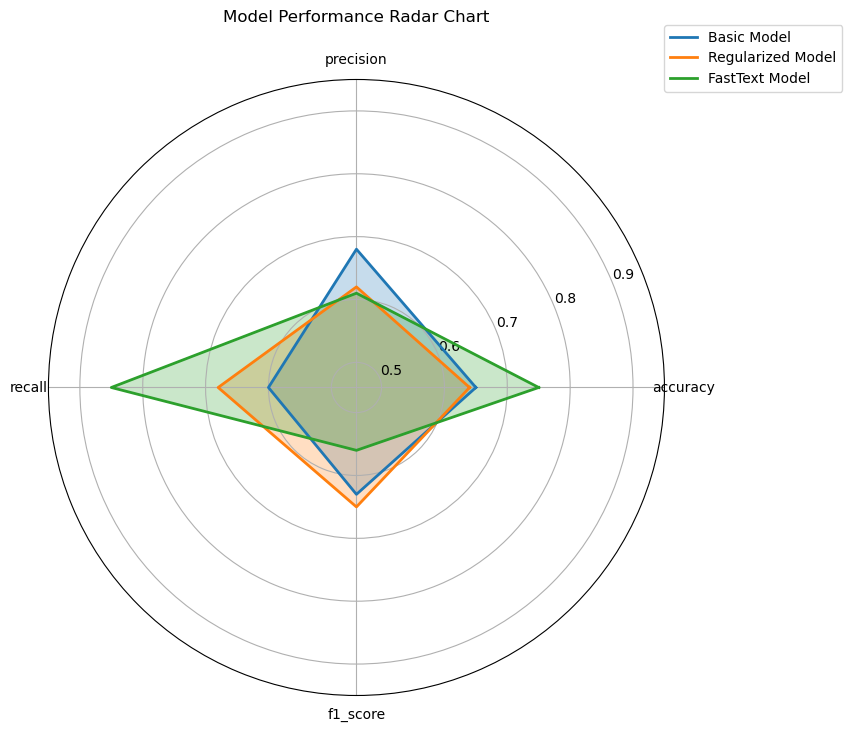

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample data
model_results = {
    "Basic Model": {
        "accuracy": 0.65,
        "precision": 0.68,
        "recall": 0.60,
        "f1_score": 0.63,
        "training_time": 240,
        "inference_time": 14.11,
    },
    "Regularized Model": {
        "accuracy": 0.64,
        "precision": 0.62,
        "recall": 0.68,
        "f1_score": 0.65,
        "training_time": 660,
        "inference_time": 38.53,
    },
    "FastText Model": {
        "accuracy": 0.75,
        "precision": 0.61,
        "recall": 0.85,
        "f1_score": 0.56,
        "training_time": 660,
        "inference_time": 39.86,
    }
}

df = pd.DataFrame(model_results).T
df.index.name = "Model"

# ============================
# 1. Performance Metrics Plot
# ============================
plt.figure(figsize=(10, 6))
metrics = ["accuracy", "precision", "recall", "f1_score"]

# Calculate dynamic y-axis limits
min_score = df[metrics].min().min() - 0.05
max_score = df[metrics].max().max() + 0.05

ax = df[metrics].plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.ylim(min_score, max_score)
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.legend(title="Metric", bbox_to_anchor=(1.05, 1))  # Move legend outside
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.2f", padding=3)

plt.tight_layout()
plt.savefig("performance.png", bbox_inches="tight")  # Save first
plt.show()  # Explicitly show the plot
plt.close()

# ============================
# 2. Training/Inference Time Plot
# ============================
plt.figure(figsize=(10, 6))
time_df = df[["training_time", "inference_time"]]
time_df.columns = ["Training (s)", "Inference (s)"]

ax = time_df.plot(kind="bar", color=["#1f77b4", "#ff7f0e"])
plt.title("Model Efficiency Comparison", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Time Metric", bbox_to_anchor=(1.05, 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", padding=3)

plt.tight_layout()
plt.savefig("efficiency.png", bbox_inches="tight")
plt.show()
plt.close()

# ============================
# 3. Radar Chart
# ============================
def create_radar_chart(models_data):
    metrics = ["accuracy", "precision", "recall", "f1_score"]
    N = len(metrics)
    
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the plot
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, polar=True)
    
    # Dynamic scaling
    all_values = [model[metric] for model in models_data.values() for metric in metrics]
    rmin = max(0, min(all_values) - 0.1)
    rmax = min(1, max(all_values) + 0.1)
    
    plt.ylim(rmin, rmax)
    plt.xticks(angles[:-1], metrics)
    
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
    for idx, (model_name, model_data) in enumerate(models_data.items()):
        values = [model_data[metric] for metric in metrics]
        values += values[:1]  # Close the plot
        ax.plot(angles, values, color=colors[idx], linewidth=2, label=model_name)
        ax.fill(angles, values, color=colors[idx], alpha=0.25)
    
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.title("Model Performance Radar Chart", y=1.08)
    plt.show()
    plt.savefig("radar.png", bbox_inches="tight")
    plt.close()

create_radar_chart(model_results)

summary: Using light archetecture (e.g., GloVe-BiLSTM, Advanced Regularized, FastText Enhanced) - (LSTM-based with attention rather than huge transformer models), you balance performance with the need for quick training and inference. This is crucial when you work with limited computational resources or need real-time processing.


In many practical scenarios, a lighter model can be 80–90% more efficient in terms of runtime — 
that is, if a transformer model takes, say, 100 seconds to process a batch, a lightweight model might complete the same task in only 10–20 seconds.

Parameter reductions: Light models may use 80–90% fewer parameters


Tailored to Casual Language:
Many traditional sarcasm detection systems are created for datasets with relatively standard language (e.g., news headlines). Your chosen models, particularly with features like subword embeddings and dynamic padding, are tailored to handle the informal, often inconsistent nature of social media language, where sarcasm is frequently implicit and context-dependent.



